In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import MaskablePPO
from stable_baselines3.common.monitor import Monitor
from typing import Dict, Any, List, Tuple, Optional
import gymnasium as gym   
from gymnasium import spaces 
import numpy as np
import networkx as nx
import random
import math

In [3]:
# ------------------------- Energy model -------------------------

def energy_for_edge(edge_data: Dict[str, Any], vehicle_params: Dict[str, float], speed_m_s: Optional[float] = None) -> float:
    """Estimate kWh required to traverse an edge.
    This is the same physical model you provided, with small safety clamps.
    """
    m = vehicle_params.get('mass_kg', 1800)
    g = 9.80665
    rho = 1.225
    CdA = vehicle_params.get('CdA', 0.62)
    Cr = vehicle_params.get('Cr', 0.015)
    regen = vehicle_params.get('regen_eff', 0.6)

    length = float(edge_data.get('length', 100.0))
    slope_deg = float(edge_data.get('slope_deg', 0.0))
    theta = np.radians(slope_deg)

    # infer speed
    if speed_m_s is None:
        speed_kph = edge_data.get('speed_kph', None)
        if speed_kph is None:
            travel_time = edge_data.get('travel_time', None)
            if travel_time is None or travel_time <= 0:
                # default to 50 km/h
                speed_m_s = 50.0 / 3.6
            else:
                speed_m_s = length / max(travel_time, 1e-6)
        else:
            speed_m_s = float(speed_kph) * 1000.0 / 3600.0

    grade_force = m * g * math.sin(theta)
    rolling_force = m * g * math.cos(theta) * Cr
    aero_force = 0.5 * rho * CdA * (speed_m_s ** 2)

    resistive_force = grade_force + rolling_force + aero_force
    energy_j = resistive_force * length

    stop_prob = float(edge_data.get('stop_prob', 0.0))
    accel_energy_j = stop_prob * 0.5 * m * (speed_m_s ** 2) * (1.0 - regen)

    congestion = float(edge_data.get('congestion_factor', 1.0))
    congestion_loss_j = length * max(congestion - 1.0, 0.0) * m * g * 0.01

    total_j = energy_j + accel_energy_j + congestion_loss_j

    total_kwh = total_j / 3.6e6

    # allow small negative to represent regen credit but clamp extreme values
    if total_kwh < -0.05:
        total_kwh = -0.05
    return float(total_kwh)



In [4]:
# -------------------- Node embeddings (spectral) --------------------

def compute_spectral_embeddings(G: nx.Graph, dim: int = 8, normalized: bool = True, add_degree: bool = True) -> np.ndarray:
    """Compute a simple spectral embedding for nodes.
    Returns an array of shape (n_nodes, dim (+1 if degree appended)).
    Uses top `dim` eigenvectors of normalized Laplacian.
    """
    A = nx.to_scipy_sparse_array(G, nodelist=list(G.nodes()), format='csr')
    # degree matrix
    degs = np.asarray(A.sum(axis=1)).flatten()
    n = A.shape[0]

    # build normalized Laplacian L = I - D^{-1/2} A D^{-1/2}
    with np.errstate(divide='ignore'):
        d_inv_sqrt = np.power(degs, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    # compute normalized adjacency
    A_norm = D_inv_sqrt @ A.toarray() @ D_inv_sqrt
    L = np.eye(n) - A_norm

    # compute eigenvectors of L; smallest non-zero eigenvectors provide embedding
    try:
        eigvals, eigvecs = np.linalg.eigh(L)
    except Exception:
        # fallback: use random embeddings
        emb = np.random.randn(n, dim)
        if add_degree:
            deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
            emb = np.hstack([emb, deg_col])
        return emb.astype(np.float32)

    # sort eigenvectors by eigenvalue ascending
    idx = np.argsort(eigvals)
    # skip the first 0 eigenvector (constant) if present
    start = 1 if eigvals[idx[0]] < 1e-8 else 0
    vecs = eigvecs[:, idx[start:start + dim]]

    emb = vecs
    if add_degree:
        deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
        emb = np.hstack([emb, deg_col])

    # normalize embeddings
    emb = emb.astype(np.float32)
    emb = (emb - emb.mean(axis=0, keepdims=True)) / (emb.std(axis=0, keepdims=True) + 1e-8)
    return emb


In [164]:
# =============================================================================
# <<< COPY AND PASTE THIS ENTIRE CLASS TO REPLACE THE PREVIOUS ONE >>>
# =============================================================================
class EVPathEnv(gym.Env):
    """
    Single EV environment with a robust reset method to guarantee solvable episodes.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, G: nx.Graph, vehicle_params: Dict[str, Any], embeddings: Optional[np.ndarray] = None,
                 seed: int = 0, debug: bool = False):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.rng = np.random.default_rng(seed)
        self.debug = debug

        self.nodes = list(G.nodes())
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
        self.n_nodes = len(self.nodes)
        self.max_episode_steps = self.n_nodes * 2

        self.shortest_paths = dict(nx.all_pairs_shortest_path_length(self.G))

        self.neighbors: List[List[int]] = []
        max_deg = 0
        for u in self.nodes:
            nbrs = [self.node_to_idx[v] for v in G.neighbors(u)]
            self.neighbors.append(nbrs)
            max_deg = max(max_deg, len(nbrs))
        self.max_degree = max_deg if max_deg > 0 else 1

        if embeddings is None:
            self.embeddings = compute_spectral_embeddings(G, dim=6)
        else:
            self.embeddings = embeddings
        self.embedding_dim = self.embeddings.shape[1]

        obs_dim = self.embedding_dim * 2 + 2
        self.observation_space = gym.spaces.Dict({
            "observation": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32),
            "action_mask": gym.spaces.Box(low=0, high=1, shape=(self.max_degree,), dtype=np.int8)
        })
        self.action_space = gym.spaces.Discrete(self.max_degree)

        self.episode_count = 0
        self.success_history = []
        self.current_difficulty = 1
        self.battery_capacity_kwh = vehicle_params.get('battery_capacity_kwh', 75.0)

        # --- <<< NEW: Create a subgraph view of only open roads for path validation >>> ---
        self.open_roads_graph = nx.Graph()
        self.open_roads_graph.add_nodes_from(self.G)
        open_edges = [(u, v) for u, v, data in self.G.edges(data=True) if data.get('status') != 'closed']
        self.open_roads_graph.add_edges_from(open_edges)


    # --- <<< CHANGED: The reset method now GUARANTEES a solvable path exists >>> ---
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1

        # Adaptive curriculum logic remains the same
        if len(self.success_history) > 100:
            success_rate = np.mean(self.success_history)
            if success_rate > 0.8 and self.current_difficulty < self.n_nodes:
                self.current_difficulty = min(self.current_difficulty + 1, self.n_nodes -1)
                if self.debug:
                    print(f"[INFO] Difficulty increased to {self.current_difficulty} at episode {self.episode_count}")
            elif success_rate < 0.5 and self.current_difficulty > 1:
                self.current_difficulty -= 1
                if self.debug:
                    print(f"[INFO] Difficulty decreased to {self.current_difficulty} at episode {self.episode_count}")
            self.success_history = []

        # Find a valid (src, dst) pair for the current difficulty
        attempts = 0
        while True:
            # 1. Pick a random source node
            self.src = random.choice(self.nodes)
            
            # 2. Find all potential destinations within the difficulty cutoff *on the main graph*
            reachable_in_main_graph = nx.single_source_shortest_path_length(self.G, self.src, cutoff=self.current_difficulty)
            
            # 3. Filter this list to find destinations that are ALSO reachable *on the open roads graph*
            possible_dst = [
                node for node in reachable_in_main_graph
                if node != self.src and nx.has_path(self.open_roads_graph, self.src, node)
            ]
            
            # 4. If we found at least one valid, solvable destination, break the loop
            if possible_dst:
                self.dst = random.choice(possible_dst)
                break
            
            attempts += 1
            if attempts > self.n_nodes * 2: # Failsafe to prevent infinite loops on disconnected graphs
                print("Could not find a solvable path after many attempts. Is the graph connected?")
                # Fallback to a simple neighbor task
                if list(self.open_roads_graph.neighbors(self.src)):
                    self.dst = random.choice(list(self.open_roads_graph.neighbors(self.src)))
                    break
                # If even that fails, we have a serious graph problem
                else:
                     raise RuntimeError(f"Node {self.src} has no open connections in the graph!")

        # Standard reset procedure
        self.current = self.src
        self.total_energy = 0.0
        self.visited = {self.src}
        self.steps = 0
        
        return self._get_dict_obs(), {}

    # The step, _get_action_mask, _make_obs_vec, and render methods remain the same as the previous corrected version.
    # Make sure you are using the version that prevents the IndexError in step().
    

    def _make_obs_vec(self) -> np.ndarray:
        current_idx = self.node_to_idx[self.current]
        dst_idx = self.node_to_idx[self.dst]
        cur_emb = self.embeddings[current_idx]
        dst_emb = self.embeddings[dst_idx]
        energy_fraction = max(0.0, (self.battery_capacity_kwh - self.total_energy) / self.battery_capacity_kwh)
        dist_to_dst = self.shortest_paths[self.current].get(self.dst, self.n_nodes)
        dist_norm = dist_to_dst / self.n_nodes
        obs_vec = np.concatenate([cur_emb, dst_emb, np.array([energy_fraction, dist_norm], dtype=np.float32)])
        return obs_vec

    def _get_dict_obs(self) -> Dict:
        return {"observation": self._make_obs_vec(), "action_mask": self._get_action_mask()}

    def _get_action_mask(self) -> np.ndarray:
        mask = np.zeros(self.max_degree, dtype=np.int8)
        current_idx = self.node_to_idx[self.current]
        nbrs = self.neighbors[current_idx]
        for i in range(len(nbrs)):
            nbr_node = self.nodes[nbrs[i]]
            edge_data = self.G[self.current][nbr_node]
            if edge_data.get("status") != "closed":
                mask[i] = 1
        return mask


    def step(self, action: int):
        action_mask = self._get_action_mask()
        valid_actions = np.where(action_mask == 1)[0]

        # Safety check: ensure chosen action is valid
        if action not in valid_actions:
            # Penalize invalid action
            reward = -50.0
            done = True
            truncated = False
            info = {"error": "Invalid (non-neighbor) action chosen."}
            if self.debug:
                print(f"[WARN] Invalid action {action} at node {self.current}")
            self.success_history.append(0)
            return self._get_dict_obs(), reward, done, truncated, info

        current_idx = self.node_to_idx[self.current]
        nbrs = self.neighbors[current_idx]
        next_idx = nbrs[action]  # Now guaranteed safe
        next_node = self.nodes[next_idx]

        # Continue with your energy and reward logic
        edge_attrs = self.G[self.current][next_node]
        e_kwh = energy_for_edge(edge_attrs, self.vehicle_params)
        self.total_energy += e_kwh

        dist_before = self.shortest_paths[self.current].get(self.dst, self.n_nodes)
        dist_after = self.shortest_paths[next_node].get(self.dst, self.n_nodes)

        reward = (dist_before - dist_after) * 1.5 - e_kwh - 0.1
        if next_node in self.visited:
            reward -= 0.5

        self.current = next_node
        self.visited.add(next_node)

        terminated = (self.current == self.dst)
        truncated = (self.steps >= self.max_episode_steps) or (self.total_energy >= self.battery_capacity_kwh)
        if terminated:
            reward += 50.0
            self.success_history.append(1)
        elif truncated:
            reward -= 25.0
            self.success_history.append(0)

        return self._get_dict_obs(), reward, terminated, truncated, {}


    def render(self, mode='human'):
        energy_frac = (self.battery_capacity_kwh - self.total_energy) / self.battery_capacity_kwh
        print(f"Step: {self.steps}, Current: {self.current}, Dst: {self.dst}, Energy Used: {self.total_energy:.2f}kWh, Battery: {energy_frac:.2%}")

In [ ]:
# ----------------------- Training helpers & debug -----------------------


class TrainingDebugCallback(BaseCallback):
    """Callback that prints and logs custom training information every `print_freq` calls to _on_step.
    It also runs a quick eval every `eval_freq` steps.
    """
    def __init__(self, eval_env: Optional[gym.Env] = None, print_freq: int = 1, eval_freq: int = 10000, verbose: int = 0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.print_freq = print_freq
        self.eval_freq = eval_freq
        self._n_calls = 0

    def _on_step(self) -> bool:
        self._n_calls += 1
        # print every `print_freq` calls
        if self._n_calls % self.print_freq == 0:
            # Attempt to print some SB3 log values if available
            try:
                vals = self.logger.name_to_value
                # pick a few useful scalars if present
                ev = vals.get('train/explained_variance', None)
                vl = vals.get('train/value_loss', None)
                pl = vals.get('train/policy_gradient_loss', None)
                if ev is not None or vl is not None or pl is not None:
                    print(f"[Callback] steps={self.num_timesteps} ev={ev} value_loss={vl} pg_loss={pl}")
            except Exception:
                pass

        if self.eval_env is not None and (self.num_timesteps % self.eval_freq == 0) and (self.num_timesteps > 0):
            mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=3, deterministic=True)
            print(f"[Eval] timesteps={self.num_timesteps} mean_reward={mean_reward:.4f} std={std_reward:.4f}")
        return True



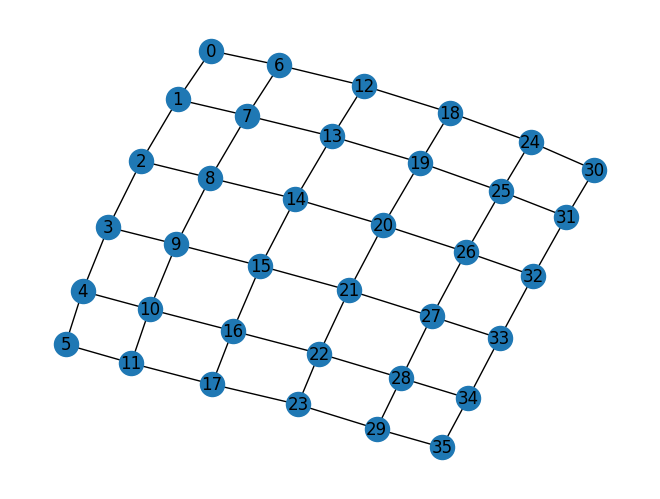

In [168]:
# Example usage -- you must define `road_network` and `update_dynamic_edge_states` in your project.
# For demonstration we'll build a small random graph.
G = nx.grid_2d_graph(6, 6)
G = nx.convert_node_labels_to_integers(G)
# add some dummy edge attributes
for u, v in G.edges():
    G[u][v]['length'] = random.uniform(50, 500)
    G[u][v]['slope_deg'] = random.uniform(-5, 5)
    G[u][v]['congestion_factor'] = random.uniform(1.0, 1.5)
    G[u][v]['stop_prob'] = random.choice([0.0, 0.2])
    G[u][v]['speed_kph'] = random.choice([30, 50])
    G[u][v]['status'] = "open" if random.random() > 0.8 else "closed"

vehicle_params = {
    'mass_kg': 1850,
    'CdA': 0.62,
    'Cr': 0.015,
    'regen_eff': 0.65,
}


nx.draw(G, with_labels=True)
import matplotlib.pyplot as plt 
plt.show()

In [334]:
vehicle_params = {
    'mass_kg': 1850,
    'CdA': 0.62,
    'Cr': 0.015,
    'regen_eff': 0.65,
    'battery_capacity_kwh': 75.0, # <<< ADD THIS
}

# 2. Setup the environment (this part is largely the same)
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.monitor import Monitor

embeddings = compute_spectral_embeddings(G, dim=6)

# This helper function is required for the ActionMasker wrapper
def extract_action_masks(env: EVPathEnv) -> np.ndarray:
    return env._get_action_mask()

def make_env():
    env = EVPathEnv(G, vehicle_params, embeddings=embeddings, debug=True)
    env = ActionMasker(env, extract_action_masks)
    env = Monitor(env)
    return env

vec_env = DummyVecEnv([make_env])

# 3. Update the MaskablePPO model definition
model = MaskablePPO(
    policy="MultiInputPolicy",
    env=vec_env,
    verbose=1,
    device="cpu",
    learning_rate=3e-4,
    ent_coef=0.01,
    n_steps=2048,      # Increased for more stable updates
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
)

# 4. Train the model (from scratch)
model.learn(total_timesteps=500_000)
model.save("ppo_ev_robust_v1")

Using cpu device
[INFO] Difficulty increased to 2 at episode 102
[INFO] Difficulty increased to 3 at episode 203
[INFO] Difficulty increased to 4 at episode 304
[INFO] Difficulty increased to 5 at episode 405
[INFO] Difficulty increased to 6 at episode 506
[INFO] Difficulty increased to 7 at episode 607
[INFO] Difficulty increased to 8 at episode 708
[INFO] Difficulty increased to 9 at episode 809
[INFO] Difficulty increased to 10 at episode 910
[INFO] Difficulty increased to 11 at episode 1011
[INFO] Difficulty increased to 12 at episode 1112
[INFO] Difficulty increased to 13 at episode 1213
[INFO] Difficulty increased to 14 at episode 1314
[INFO] Difficulty increased to 15 at episode 1415
[INFO] Difficulty increased to 16 at episode 1516
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 51.4     |
| time/              |          |
|    fps             | 1138     |
|    iterations      | 1        |
|    time_el

KeyboardInterrupt: 

In [190]:
# Quick evaluation
mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=5, deterministic=True)
print(f"Final eval mean_reward={mean_reward:.4f} std={std_reward:.4f}")


Final eval mean_reward=-50.0000 std=0.0000


In [333]:
print("--- Starting Demo Rollout ---")
# Load the model you just saved
model = MaskablePPO.load("ppo_ev_robust_v1", env=vec_env)

# Reset the environment to get a new task
obs = vec_env.reset()

# Get the start and end nodes for this episode
start_node = vec_env.get_attr("src")[0]
target_node = vec_env.get_attr("dst")[0]
path = [start_node]

print(f"Start: {start_node}, Target: {target_node}")
print("-----------------------------")

done = False
step = 0
max_steps = 200

while not done and step < max_steps:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    current_node = vec_env.get_attr("current")[0]
    path.append(current_node)
    
    step += 1
    # Robustly check for episode termination from the info dictionary
    episode_done = info[0].get("TimeLimit.truncated", False) or info[0].get("terminal_observation") is not None

    if step % 5 == 0 or episode_done:
        vec_env.render()

    if isinstance(done, (list, np.ndarray)):
        done = done[0]
    
    if episode_done:
        break

# --- Final Path Reporting ---
print("\n--- Demo Finished ---")
# Remove consecutive duplicates for a cleaner path display
clean_path = [node for i, node in enumerate(path) if i == 0 or node != path[i-1]]
print(f"Start={start_node}, Target={target_node}")
print(f"  Path ({len(clean_path)-1} steps): {clean_path}")

if clean_path[-1] == target_node:
    print("  Status: ✅ Successfully reached destination!")
else:
    print("  Status: ❌ Did not reach destination.")
print("---------------------")

--- Starting Demo Rollout ---
Start: 15, Target: 21
-----------------------------

--- Demo Finished ---
Start=15, Target=21
  Path (1 steps): [15, 21]
  Status: ✅ Successfully reached destination!
---------------------
